# Nibabel Basics Notebook
### *Learning how to load and view MRI scans*

## Import Libraries
We need nibabel for MRI files and matplotlib for plotting.

In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

## Upload an MRI File (.nii.gz)
Upload any NIfTI file.

In [5]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

## Load MRI File
Nibabel loads the 3D MRI volume as a NumPy array.

In [14]:
file_path = 'mni152.nii.gz'
mri = nib.load(file_path).get_fdata()
print('MRI Shape:', mri.shape)

MRI Shape: (207, 256, 215)


## Visualize a Middle Slice
MRI is 3D. We view one slice at a time.

(np.float64(-0.5), np.float64(255.5), np.float64(206.5), np.float64(-0.5))

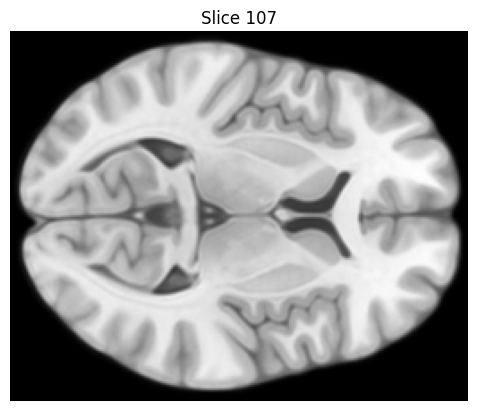

In [15]:
slice_index = mri.shape[2] // 2
plt.imshow(mri[:, :, slice_index], cmap='gray')
plt.title(f'Slice {slice_index}')
plt.axis('off')

## Extract All Slices
Convert 3D MRI into 2D slices.

In [16]:
slices = [mri[:, :, i] for i in range(mri.shape[2])]
len(slices)

215

## Normalize a Slice
Normalization improves contrast.

(np.float64(-0.5), np.float64(255.5), np.float64(206.5), np.float64(-0.5))

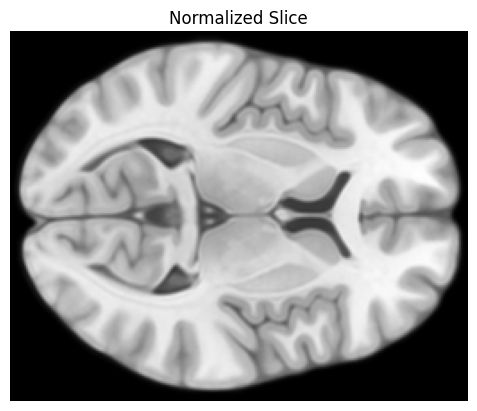

In [17]:
norm_slice = (mri[:, :, slice_index] - np.min(mri)) / (np.max(mri) - np.min(mri))
plt.imshow(norm_slice, cmap='gray')
plt.title('Normalized Slice')
plt.axis('off')

## Resize Slice (Used in ML Preprocessing)

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

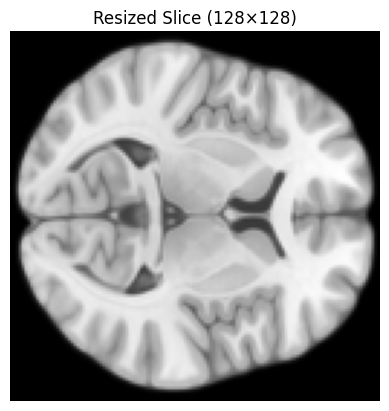

In [18]:
import tensorflow as tf
resized = tf.image.resize(norm_slice[..., None], (128, 128))
plt.imshow(resized.numpy().squeeze(), cmap='gray')
plt.title('Resized Slice (128×128)')
plt.axis('off')

## **Exercises**
1. Load **another** MRI file and visualize 5 slices.
2. Write a function `plot_slices(volume, indices)` to plot given slice numbers.
3. Create a function to normalize **all** slices and return the new array.
4. Resize all slices to 128×128 and count how many slices contain tumor pixels (if mask available).


(207, 256, 215)


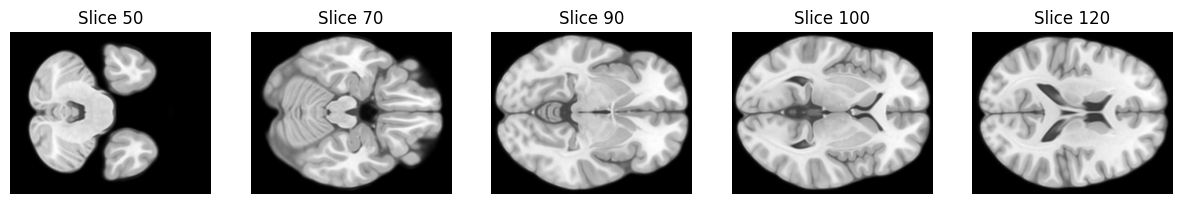

In [6]:
file = 'mni152.nii.gz'
images = nib.load(file)
data = images.get_fdata()
print(data.shape)
#got (207, 256, 215)
randomslice_indices = [50, 70, 90, 100, 120]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(randomslice_indices):
    plt.subplot(1, 5, i + 1)
    # Using the 3rd dimension (axial view)
    plt.imshow(data[:, :, idx], cmap='gray')
    plt.title(f"Slice {idx}")
    plt.axis('off')
plt.show()

In [1]:
def plot_slices(volume, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        #checking if the slice index is within bounds
        if idx < volume.shape[2]:
            plt.subplot(1, len(indices), i + 1)
            plt.imshow(volume[:, :, idx], cmap='gray')
            plt.title(f"Slice {idx}")
            plt.axis('off')
    plt.show()

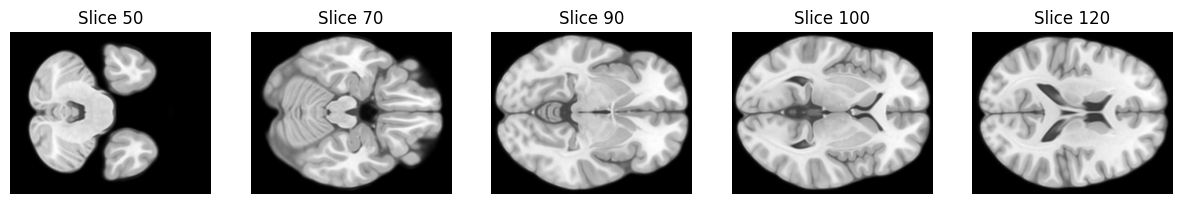

In [7]:
#test
plot_slices(data, [50, 70, 90, 100, 120])

In [9]:
def normalize(volume):
    min_val = np.min(volume)
    max_val = np.max(volume)
    if max_val - min_val == 0:
        return volume
    return (volume - min_val) / (max_val - min_val)
normalized_data = normalize(data)
#verification
print(f"Original Max Value: {np.max(data)}")
print(f"Normalized Max Value: {np.max(normalized_data)}") # Should be 1.0

Original Max Value: 91.46501398086548
Normalized Max Value: 1.0


In [11]:
import torch
import torch.nn.functional as F
import numpy as np
#resize all slices to 128x128 using PyTorch
depth = normalized_data.shape[2]
resized_slices = []
for i in range(depth):
    slice_2d = normalized_data[:, :, i]
    tensor = torch.tensor(slice_2d).float()
    #addign fake dimensions
    tensor = tensor.unsqueeze(0).unsqueeze(0)
    #resizing
    resized = F.interpolate(tensor, size=(128, 128), mode='bilinear', align_corners=False)
    #remove fake dimensions
    resized_slices.append(resized.squeeze().numpy())
#stack list back into a 3D numpy array
resized_volume = np.array(resized_slices).transpose(1, 2, 0)
#check
print(f"Old Shape: {normalized_data.shape}")
print(f"New Shape: {resized_volume.shape}")
#count slices with 'tissue'
tissue_slice_count = 0
for i in range(resized_volume.shape[2]):
    if np.any(resized_volume[:, :, i] > 0.1):
        tissue_slice_count += 1
print(f"Number of slices containing brain tissue: {tissue_slice_count}")

Old Shape: (207, 256, 215)
New Shape: (128, 128, 215)
Number of slices containing brain tissue: 212
